## Import packages

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1rPk34EPWP7cT1OBC9sL1ow0nT2iYG_Q1


Downloading...
From (original): https://drive.google.com/u/0/uc?id=1rPk34EPWP7cT1OBC9sL1ow0nT2iYG_Q1
From (redirected): https://drive.google.com/uc?id=1rPk34EPWP7cT1OBC9sL1ow0nT2iYG_Q1&confirm=t&uuid=ff5847e6-343e-4050-ab00-0f11ad748e24
To: /content/DownSyndrome.zip
100% 31.9M/31.9M [00:00<00:00, 42.1MB/s]


In [3]:
!unzip DownSyndrome.zip
!rm -rf DownSyndrome.zip
!mkdir data_split

Archive:  DownSyndrome.zip
   creating: DownSyndrome/
   creating: DownSyndrome/downSyndrome/
  inflating: DownSyndrome/downSyndrome/down_1.jpg  
  inflating: DownSyndrome/downSyndrome/down_10.jpg  
  inflating: DownSyndrome/downSyndrome/down_100.jpg  
  inflating: DownSyndrome/downSyndrome/down_1000.jpg  
  inflating: DownSyndrome/downSyndrome/down_1001.jpg  
  inflating: DownSyndrome/downSyndrome/down_1002.jpg  
  inflating: DownSyndrome/downSyndrome/down_1003.jpg  
  inflating: DownSyndrome/downSyndrome/down_1004.jpg  
  inflating: DownSyndrome/downSyndrome/down_1005.jpg  
  inflating: DownSyndrome/downSyndrome/down_1006.jpg  
  inflating: DownSyndrome/downSyndrome/down_1007.jpg  
  inflating: DownSyndrome/downSyndrome/down_1008.jpg  
  inflating: DownSyndrome/downSyndrome/down_1009.jpg  
  inflating: DownSyndrome/downSyndrome/down_101.jpg  
  inflating: DownSyndrome/downSyndrome/down_1010.jpg  
  inflating: DownSyndrome/downSyndrome/down_1011.jpg  
  inflating: DownSyndrome/downSyn

## Load and explore the dataset

In [4]:
# raw_df = pd.read_excel("/content/diabetic_data/train1.xlsx")
image_dir = "/content/DownSyndrome"

In [5]:
import os
import shutil
import random

def split_data(
    source_dir,
    output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
):

    # Pastikan rasio sudah benar (opsional, karena 0.7 + 0.15 + 0.15 = 1.0)
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Rasio train, val, dan test harus berjumlah 1."

    # Hapus folder output jika sudah ada untuk mencegah duplikasi
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    # Buat struktur folder awal: train, val, test (subfolder akan dibuat dinamis sesuai kelas)
    for split_name in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split_name), exist_ok=True)

    # Dapatkan daftar subfolder kelas di source_dir
    # Misalnya: ['ringan', 'berat']
    class_names = [d for d in os.listdir(source_dir)
                   if os.path.isdir(os.path.join(source_dir, d))]

    # Untuk setiap kelas, lakukan pembagian data
    for class_name in class_names:
        print(f"Memproses kelas: {class_name}")

        # Buat subfolder class di train, val, dan test
        train_class_dir = os.path.join(output_dir, 'train', class_name)
        val_class_dir = os.path.join(output_dir, 'val', class_name)
        test_class_dir = os.path.join(output_dir, 'test', class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Ambil semua file dari subfolder kelas
        class_source_dir = os.path.join(source_dir, class_name)
        files = [f for f in os.listdir(class_source_dir)
                 if os.path.isfile(os.path.join(class_source_dir, f))]

        # Acak urutan file
        random.shuffle(files)

        # Hitung jumlah file train, val, test
        total_files = len(files)
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count  # sisanya untuk test

        # Bagi file sesuai indeks
        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]

        # Copy file ke folder masing-masing
        for f in train_files:
            shutil.copy2(os.path.join(class_source_dir, f),
                         os.path.join(train_class_dir, f))

        for f in val_files:
            shutil.copy2(os.path.join(class_source_dir, f),
                         os.path.join(val_class_dir, f))

        for f in test_files:
            shutil.copy2(os.path.join(class_source_dir, f),
                         os.path.join(test_class_dir, f))

        print(f"  Total   : {total_files} file")
        print(f"  Train   : {len(train_files)} file")
        print(f"  Val     : {len(val_files)} file")
        print(f"  Test    : {len(test_files)} file\n")

    print("Proses splitting data selesai.")

# Contoh penggunaan
if __name__ == "__main__":
    source_folder = "DownSyndrome"     # lokasi dataset yang sudah diekstrak
    output_folder = "data_split"  # folder hasil split

    split_data(
        source_dir=source_folder,
        output_dir=output_folder,
        train_ratio=0.7,   # 70% untuk train
        val_ratio=0.15,    # 15% untuk val
        test_ratio=0.15    # 15% untuk test
    )


Memproses kelas: healty
  Total   : 1499 file
  Train   : 1049 file
  Val     : 224 file
  Test    : 226 file

Memproses kelas: downSyndrome
  Total   : 1500 file
  Train   : 1050 file
  Val     : 225 file
  Test    : 225 file

Proses splitting data selesai.


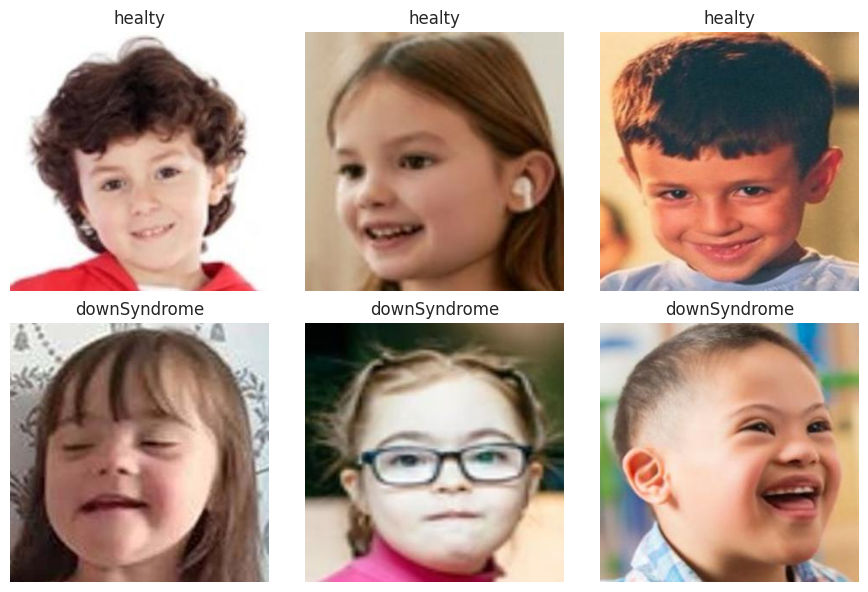

In [6]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def visualize_data_split(data_split_dir, subset='train', n_samples=3):

    # Pastikan subset folder ada
    subset_dir = os.path.join(data_split_dir, subset)
    if not os.path.isdir(subset_dir):
        print(f"Folder subset '{subset_dir}' tidak ditemukan.")
        return

    # Dapatkan nama-nama kelas di subset ini
    class_names = [
        d for d in os.listdir(subset_dir)
        if os.path.isdir(os.path.join(subset_dir, d))
    ]
    if not class_names:
        print(f"Tidak ada subfolder kelas di dalam '{subset_dir}'.")
        return

    # Hitung jumlah kelas
    n_classes = len(class_names)

    # Siapkan canvas subplot
    # Baris = n_classes, Kolom = n_samples
    fig, axes = plt.subplots(n_classes, n_samples,
                             figsize=(n_samples * 3, n_classes * 3))

    # Jika hanya 1 kelas, axes mungkin tidak berbentuk 2D, kita "ravel" agar seragam
    if n_classes == 1 and n_samples == 1:
        # Kasus spesifik hanya 1 kelas & 1 sample
        axes = [axes]  # jadikan list agar indexing tetap mudah
    else:
        axes = axes.ravel()  # array 1D, total elemen = n_classes * n_samples

    pos = 0  # posisi index di axes
    for class_name in class_names:
        # Ambil folder kelas
        class_dir = os.path.join(subset_dir, class_name)
        # Kumpulkan semua file gambar
        all_files = [
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f))
        ]
        # Acak dan pilih n_samples (atau kurang jika file tidak cukup)
        random.shuffle(all_files)
        chosen_files = all_files[:n_samples]

        for f in chosen_files:
            image_path = os.path.join(class_dir, f)
            try:
                img = Image.open(image_path)
                axes[pos].imshow(img)
                axes[pos].set_title(f"{class_name}")
                axes[pos].axis("off")
                pos += 1
            except Exception as e:
                print(f"Gagal membuka {image_path}: {e}")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Contoh penggunaan:
    data_split_dir = "data_split"     # folder utama (berisi train, val, test)
    visualize_data_split(data_split_dir, subset="train", n_samples=3)
    # Anda juga bisa memanggil untuk subset 'val' atau 'test':
    # visualize_data_split(data_split_dir, subset="val", n_samples=3)
    # visualize_data_split(data_split_dir, subset="test", n_samples=3)


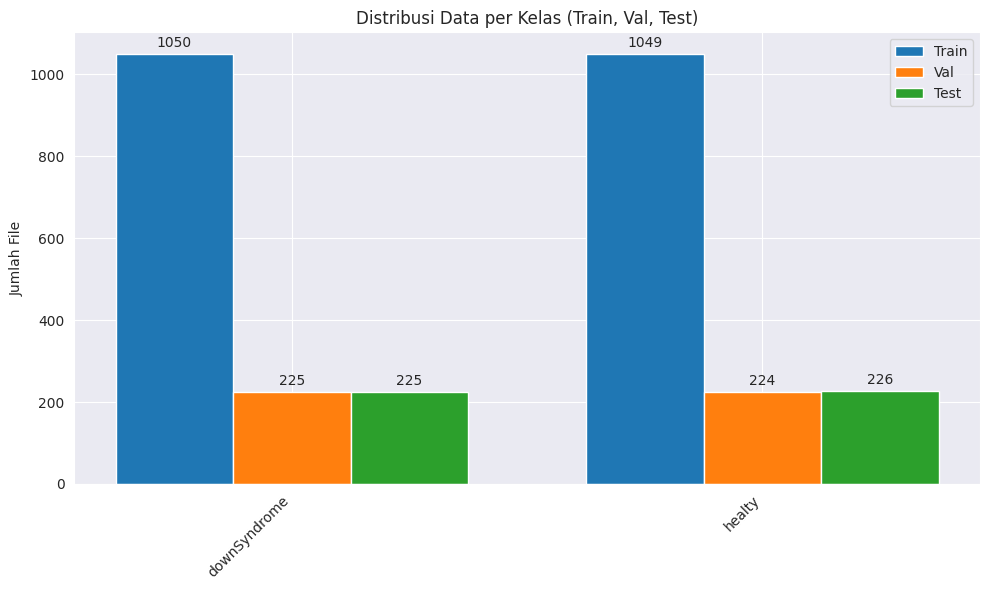

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Ganti path ini dengan folder utama berisi subfolder 'train', 'val', dan 'test'
data_split_dir = "data_split"

subsets = ['train', 'val', 'test']

# 1. Kumpulkan nama-nama kelas dari semua subset
all_classes = set()
for subset in subsets:
    subset_path = os.path.join(data_split_dir, subset)
    if not os.path.isdir(subset_path):
        print(f"Folder {subset_path} tidak ditemukan. Akan dilewati.")
        continue
    classes_in_subset = [
        d for d in os.listdir(subset_path)
        if os.path.isdir(os.path.join(subset_path, d))
    ]
    all_classes.update(classes_in_subset)

# Urutkan nama kelas agar lebih rapi
all_classes = sorted(list(all_classes))

# 2. Persiapkan dictionary untuk menyimpan jumlah file
#    counts[class_name][subset] = jumlah file
counts = {class_name: {s: 0 for s in subsets} for class_name in all_classes}

# 3. Hitung jumlah file di setiap subset untuk setiap kelas
for subset in subsets:
    subset_path = os.path.join(data_split_dir, subset)
    if not os.path.isdir(subset_path):
        continue
    for class_name in all_classes:
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):
            files = [
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ]
            counts[class_name][subset] = len(files)
        else:
            # Jika folder kelas tidak ada di subset ini, set 0
            counts[class_name][subset] = 0

# 4. Membuat grouped bar chart
#    - x-axis: daftar kelas
#    - setiap kelas memiliki 3 bar (train, val, test)
x = np.arange(len(all_classes))  # posisi x untuk kelas
width = 0.25                     # lebar setiap bar
offsets = [-width, 0, width]     # offset untuk train, val, test

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar untuk setiap subset
for i, subset in enumerate(subsets):
    subset_counts = [counts[class_name][subset] for class_name in all_classes]
    bar_x = x + offsets[i]

    # Gambar bar
    rects = ax.bar(
        bar_x,
        subset_counts,
        width=width,
        label=subset.capitalize()
    )

    # Menambahkan angka di atas tiap bar
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height}',
            xy=(rect.get_x() + rect.get_width()/2, height),
            xytext=(0, 3),   # jarak teks 3 pts di atas puncak bar
            textcoords="offset points",
            ha='center', va='bottom'
        )

# Set label, judul, dan legend
ax.set_xticks(x, labels=all_classes, rotation=45, ha='right')
ax.set_ylabel("Jumlah File")
ax.set_title("Distribusi Data per Kelas (Train, Val, Test)")
ax.legend()

plt.tight_layout()
plt.show()


## Data preprocessing

### Handle imbalanced data

### Visualize the data

### Split dataset

In [8]:
testDir = '/content/data_split/test'
trainDir = '/content/data_split/train'
validDir = '/content/data_split/val'

In [9]:
val_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen = ImageDataGenerator(#rotation_range=90,
                                    #brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     #validation_split=0.15,
                                    zoom_range=0.15,
                                    fill_mode="constant",
                                    cval=0.1,
                                    rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

### Data augmentation

In [10]:
batch_size = 32
img_width, img_height = 224,224

train_generator = train_datagen.flow_from_directory(
    directory=trainDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True
)

validation_generator = val_datagen.flow_from_directory(
    directory=validDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

test_generator =  test_datagen.flow_from_directory(
    testDir,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_width, img_height),
    shuffle = False
)

Found 2099 images belonging to 2 classes.
Found 449 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


### Data generators

In [11]:
list(train_generator.class_indices)

['downSyndrome', 'healty']

## Build a model

### Create base model

In [12]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.InceptionResNetV2(
    weights='imagenet',
    input_shape=IMG_SHAPE,
    include_top=False,
)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [13]:
base_model.summary()

Model: "inception_resnet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 54,276,192 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [14]:
# fine tune some layers
print("Number of layers in the base model: ", len(base_model.layers))

for layer in base_model.layers[:-1500]:
    layer.trainable = False

print("Number of freezed layers: ", len(base_model.layers[:-1500]))
print("Number of trainable layers: ", len(base_model.layers) - len(base_model.layers[:-1500]))

Number of layers in the base model:  780
Number of freezed layers:  0
Number of trainable layers:  780


### Create new model on top

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) # reduce overfitting and for regularization

outputs = Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_resnet_v2         │ (None, 5, 5, 1536)    │ 54,336,736 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1536)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1536)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      1,537 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 54,338,273 (207.28 MB)

 Trainable params: 54,277,729 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

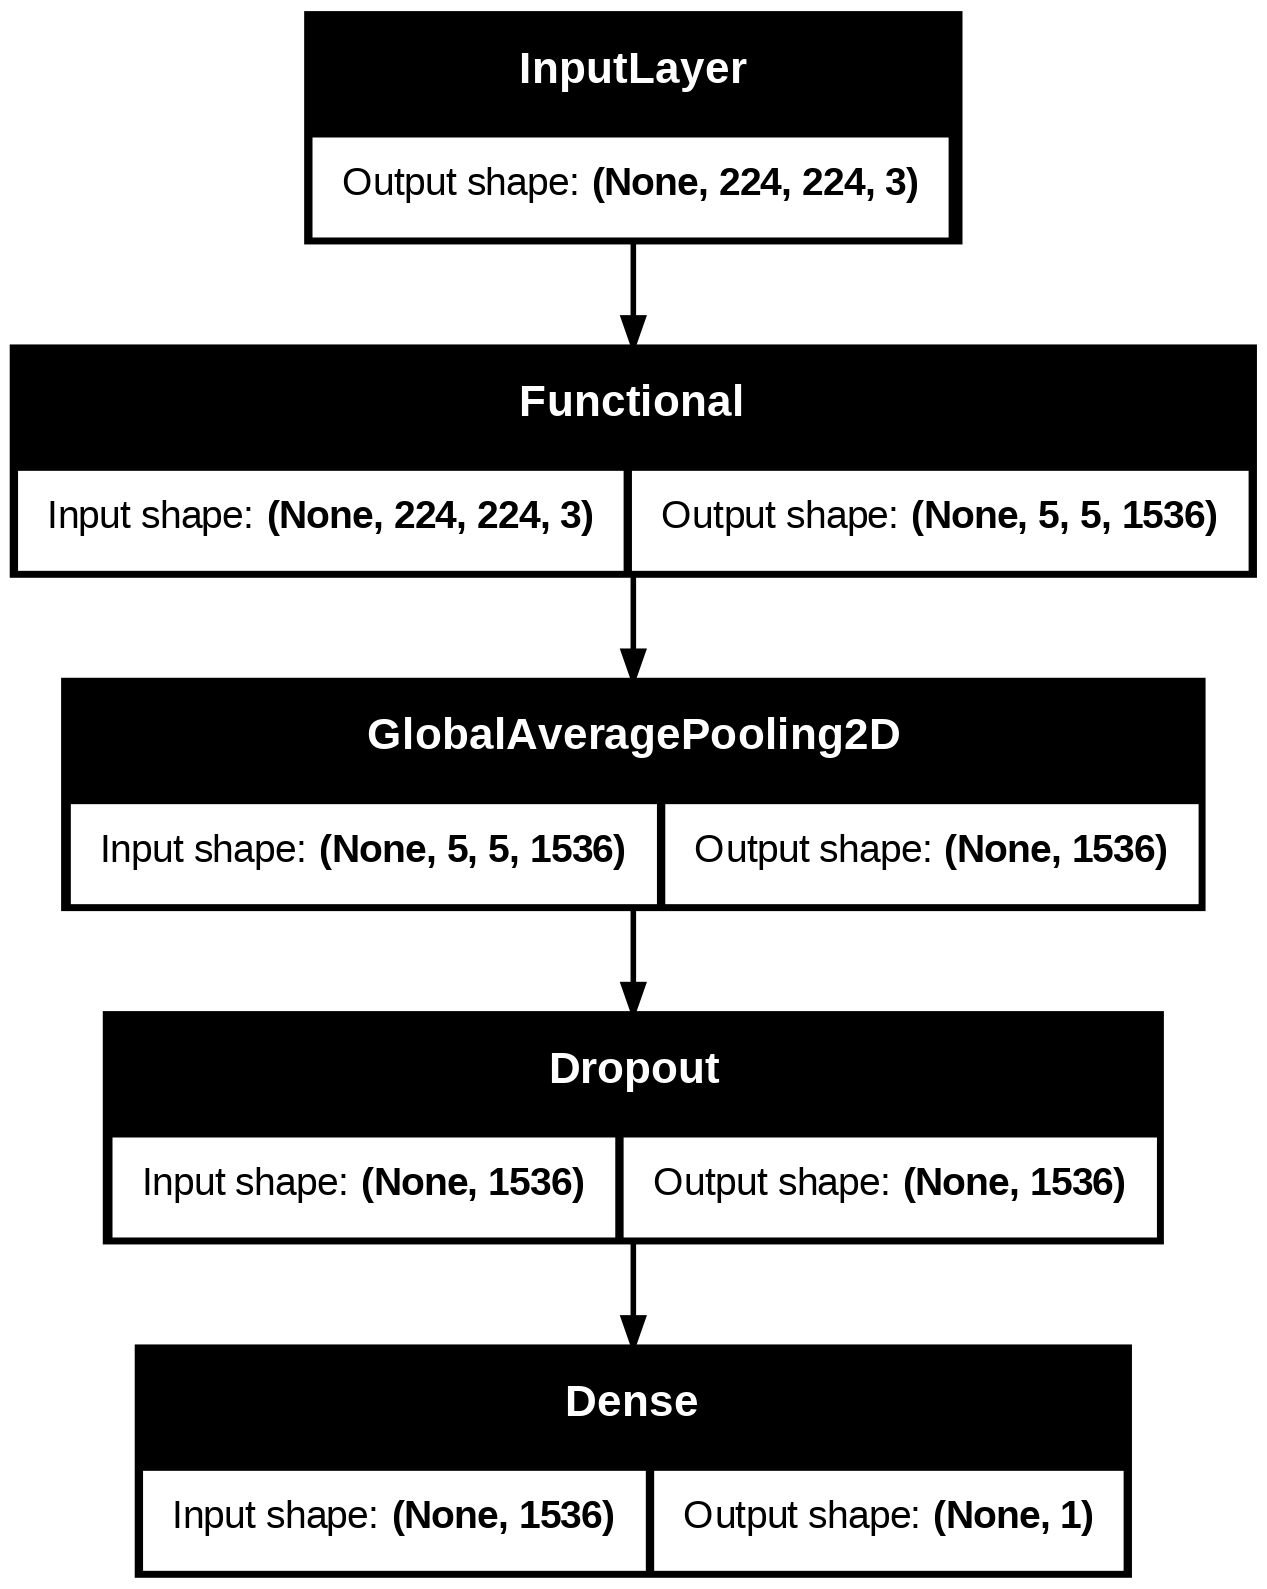

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Callbacks

In [17]:
# model check point
mc = ModelCheckpoint(
    filepath="InceptionResNetV2.keras", monitor="val_accuracy", verbose=1, save_best_only=True
)

# early stopping
es = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

### Compile and train the model

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(1e-5), # 0.00001
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)

In [19]:
start = dt.datetime.now()
history = model.fit(
    train_generator, validation_data=validation_generator, epochs=30, verbose=1, callbacks=[mc, es]
)
end = dt.datetime.now()
print("Duration: {}".format(end - start))

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5269 - loss: 0.7177
Epoch 1: val_accuracy improved from -inf to 0.65702, saving model to InceptionResNetV2.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.5270 - loss: 0.7176 - val_accuracy: 0.6570 - val_loss: 0.6506
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5927 - loss: 0.6701
Epoch 2: val_accuracy improved from 0.65702 to 0.68820, saving model to InceptionResNetV2.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 769ms/step - accuracy: 0.5927 - loss: 0.6701 - val_accuracy: 0.6882 - val_loss: 0.6237
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6372 - loss: 0.6320
Epoch 3: val_accuracy improved from 0.68820 to 0.71047, saving model to InceptionResNetV2.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 776ms/step - accuracy: 0.6372 - loss: 0.6320 - val_accuracy: 0.7105 - val_loss: 0.5862
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6860 - loss: 0.5957
Epoch 4: val_accuracy 

### Plot training and validation history

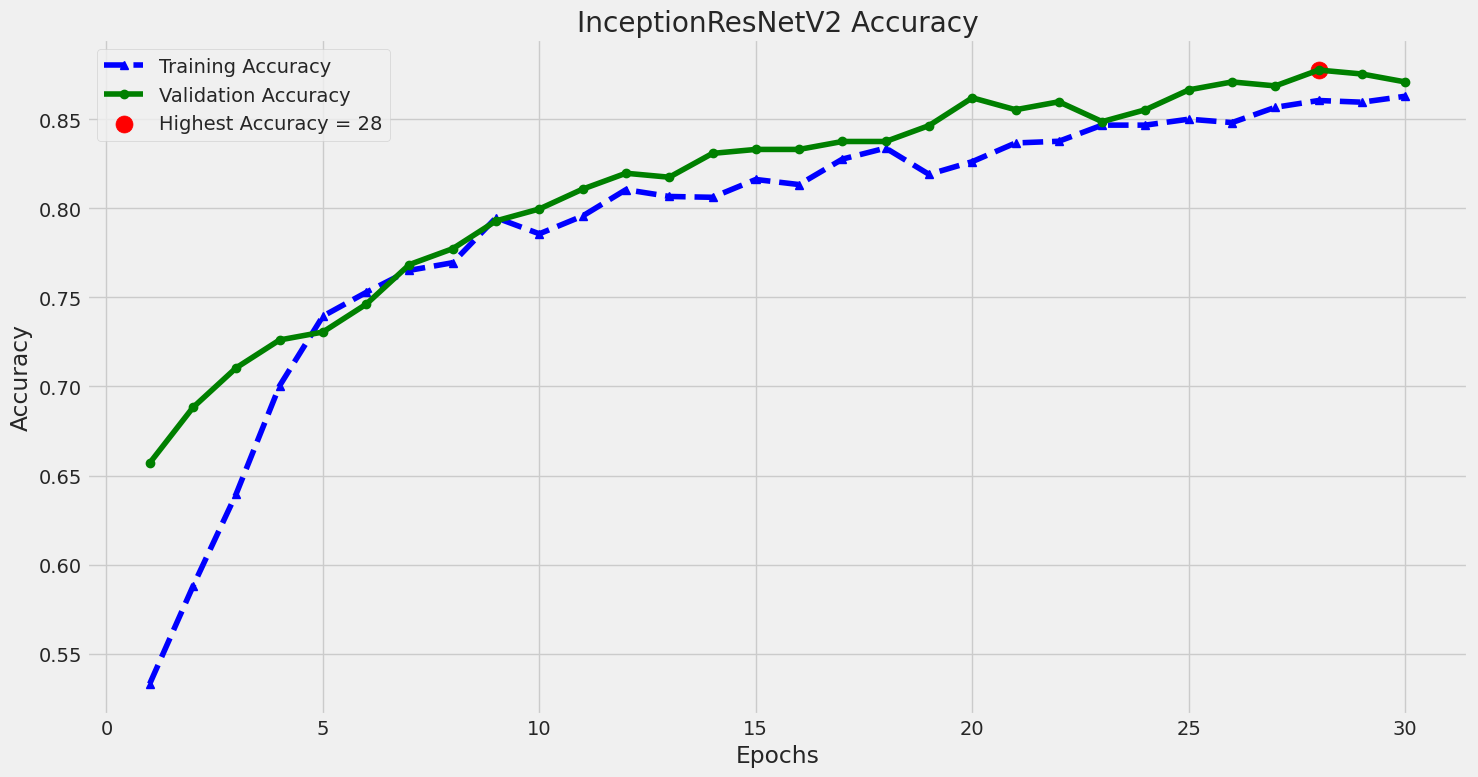

In [20]:
# visualize training and validation history
loss = history.history["loss"]
acc = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

loss_label = "Lowest Loss = " + str(index_loss + 1)
acc_label = "Highest Accuracy = " + str(index_acc + 1)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 8))


plt.subplot(1, 1, 1)
plt.plot(epochs, acc, 'b^--', label="Training Accuracy")
plt.plot(epochs, val_acc, "go-", label="Validation Accuracy")
plt.scatter(index_acc + 1, val_highest, s=150, c="red", marker="o", label=acc_label)
plt.title("InceptionResNetV2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('InceptionResNetV2_Accuracy.png', dpi=300)
plt.legend()

plt.tight_layout()
plt.show()

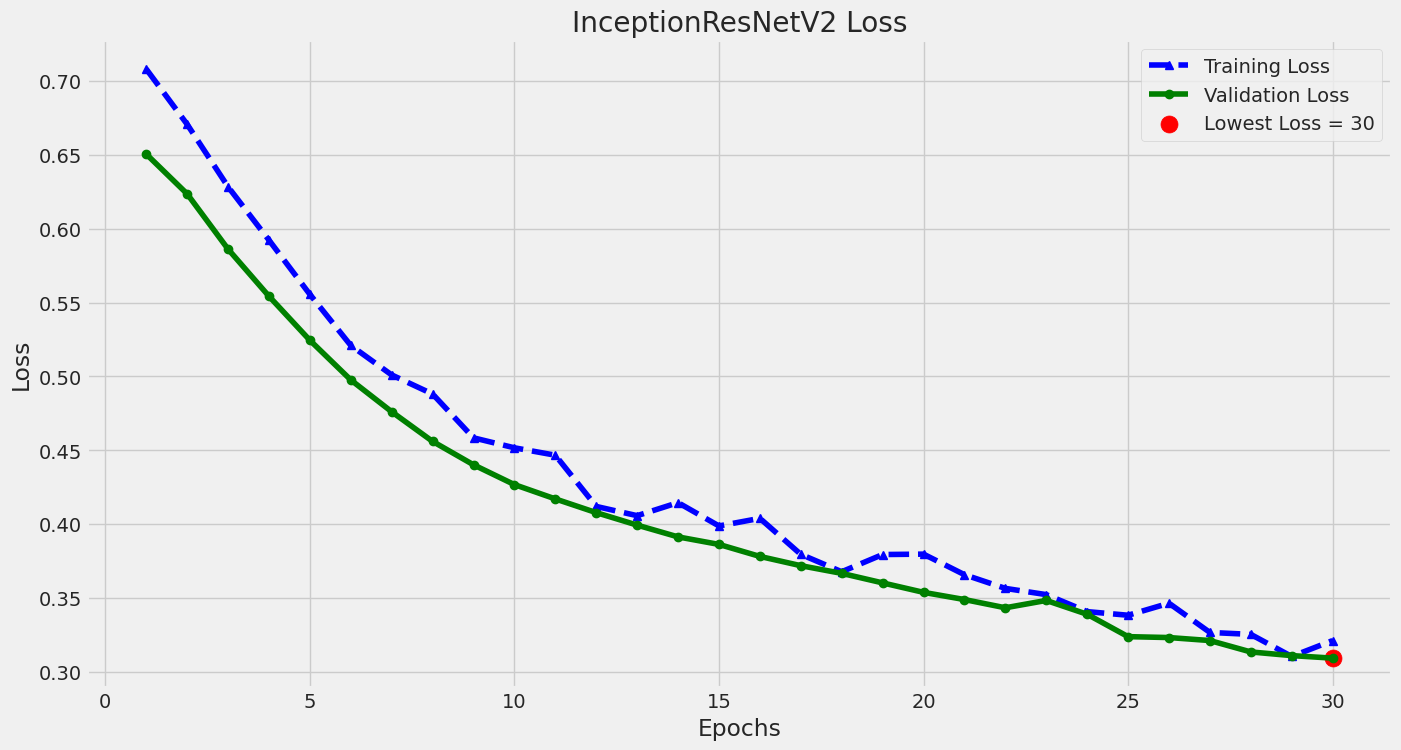

In [21]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 8))

plt.subplot(1, 1, 1)
plt.plot(epochs, loss, 'b^--', label="Training Loss")
plt.plot(epochs, val_loss, "go-", label="Validation Loss")
plt.scatter(index_loss + 1, val_lowest, s=150, c="red", marker="o", label=loss_label)
plt.title("InceptionResNetV2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('InceptionResNetV2_Loss.png', dpi=300)
plt.legend()


### Model evaluation

In [22]:
# model evaluation
loss, accuracy = model.evaluate(validation_generator)
print(f'Training Loss: {loss}, Training Accuracy: {accuracy}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8864 - loss: 0.2779
Training Loss: 0.3092838525772095, Training Accuracy: 0.8708240389823914


## Predict test data

In [23]:
# predict test data
y_pred = model.predict(test_generator)
y_pred[:5]

15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


array([[0.05699834],
       [0.02505092],
       [0.00602187],
       [0.0048035 ],
       [0.00466551]], dtype=float32)

In [24]:
y_pred[1]

array([0.02505092], dtype=float32)

In [25]:
y_preds = []
for i in y_pred:
    if i > 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)
print(y_preds[:100])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
y_trues = test_generator.classes
print(y_trues[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Classification report

In [27]:
# classification report
print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       225
           1       0.93      0.81      0.87       226

    accuracy                           0.88       451
   macro avg       0.88      0.88      0.88       451
weighted avg       0.88      0.88      0.88       451



### Confusion matrix

array([[211,  14],
       [ 42, 184]])

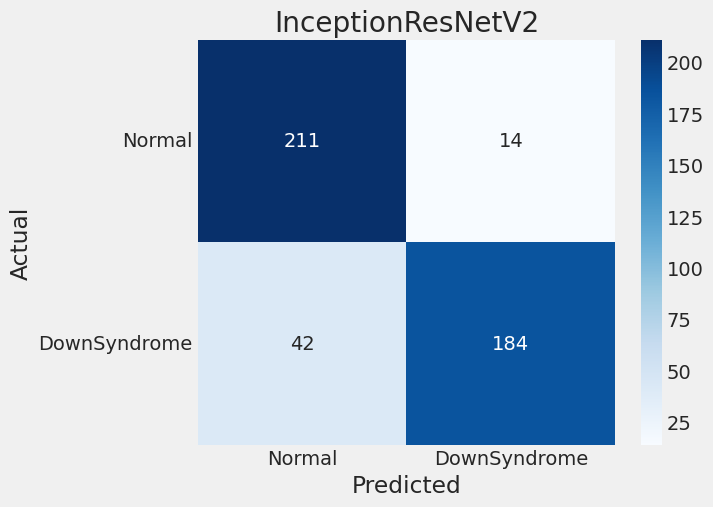

In [28]:
# Plot a confusion matrix
cm = confusion_matrix(y_trues, y_preds)
display(cm)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xticklabels(["Normal", "DownSyndrome"])
ax.set_yticklabels(["Normal", "DownSyndrome"], rotation=0)
ax.set_title("InceptionResNetV2")
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
plt.savefig('InceptionResNetV2_CM.png', dpi=300)
plt.show()

In [29]:
filename = test_generator.filenames
results = pd.DataFrame(
    {
        "Filename": filename,
        "Actual": y_trues,
        "Predictions": y_preds,
    }
)
results

Filename  Actual  Predictions
0    downSyndrome/down_1004.jpg       0            0
1     downSyndrome/down_102.jpg       0            0
2    downSyndrome/down_1035.jpg       0            0
3    downSyndrome/down_1043.jpg       0            0
4    downSyndrome/down_1044.jpg       0            0
..                          ...     ...          ...
446       healty/healty_976.jpg       1            1
447       healty/healty_979.jpg       1            0
448        healty/healty_98.jpg       1            1
449       healty/healty_986.jpg       1            1
450       healty/healty_987.jpg       1            1

[451 rows x 3 columns]

In [30]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=results)

https://docs.google.com/spreadsheets/d/1N2aO1eOdCW6ogm851g4FIGjwYZAmat_d0mouM7dxtI0/edit#gid=0


### Visualize prediction result

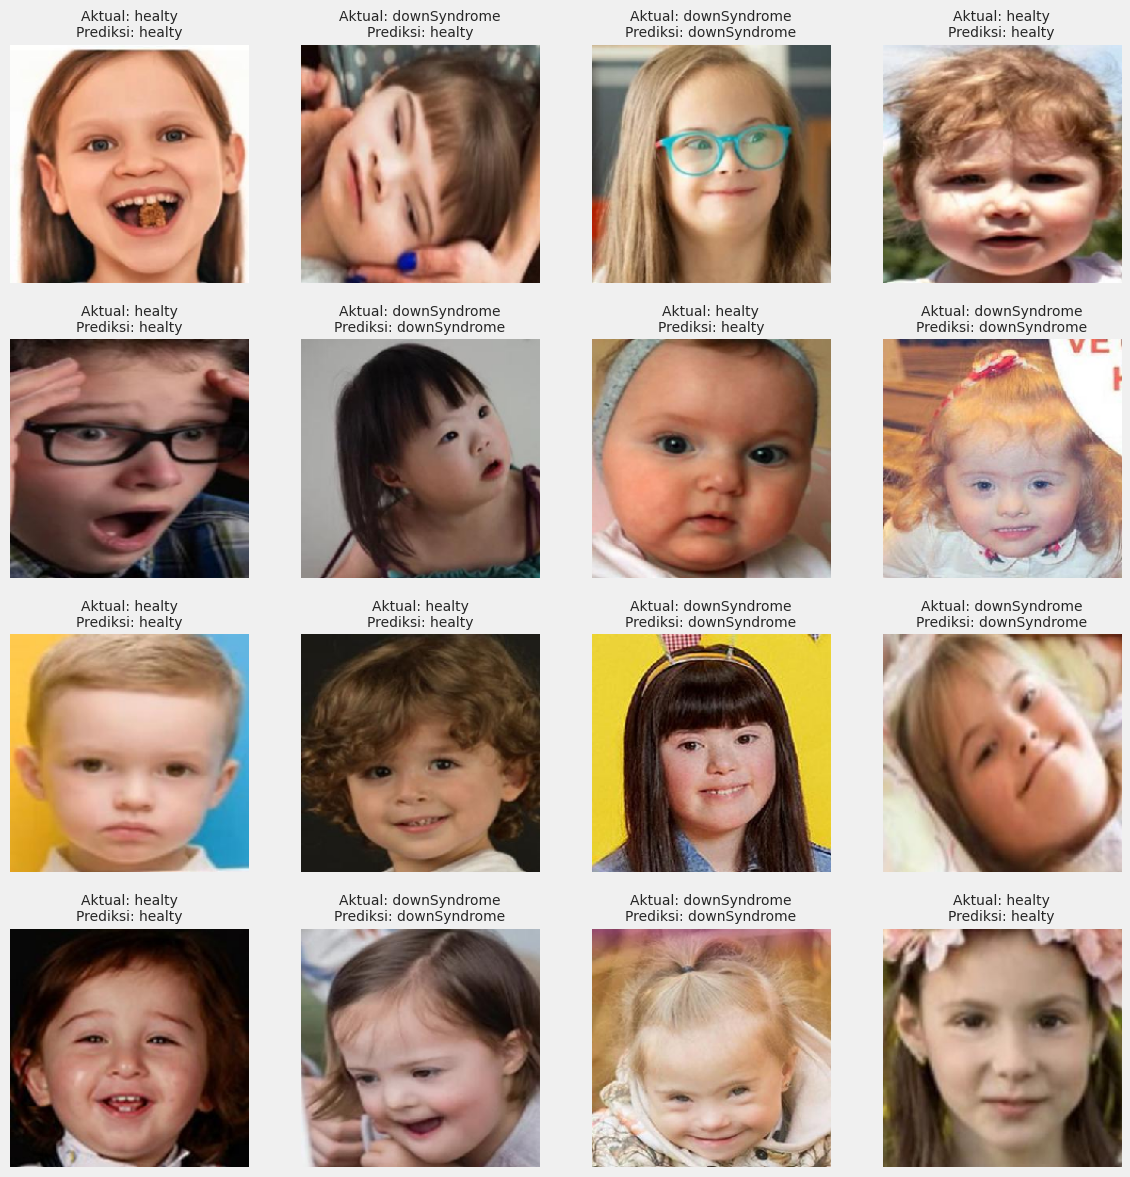

In [34]:
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

n = 16  # 4x4 grid
plt.figure(figsize=(12, 12))

# Get class names from the generator's class_indices
class_names = list(train_generator.class_indices.keys())

# Ambil total jumlah gambar yang tersedia
total_images = len(results["Filename"])

# Pilih n indeks unik secara acak
random_indices = random.sample(range(total_images), n)

for i, idx in enumerate(random_indices):
    ax = plt.subplot(4, 4, i + 1)
    img_path = os.path.join(image_dir, results["Filename"][idx])
    img = load_img(img_path, target_size=(224, 224))
    ax.imshow(img)
    ax.set_title(
        "Aktual: {}\nPrediksi: {}".format(
            class_names[results["Actual"][idx]],
            class_names[results["Predictions"][idx]],
        ),
        fontsize=10,
    )
    ax.axis("off")
plt.tight_layout()
plt.show()

## Predict new image

SINGLE IMAGE TEST:
Loading image: /content/data_split/test/downSyndrome/down_1044.jpg
Image shape after preprocessing: (1, 224, 224, 3)
Image pixel value range: 0.0039 to 1.0000

Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Binary classification prediction value: 0.0047

Using threshold: 0.5
Model predicts: Down Syndrome
Confidence: 0.9953


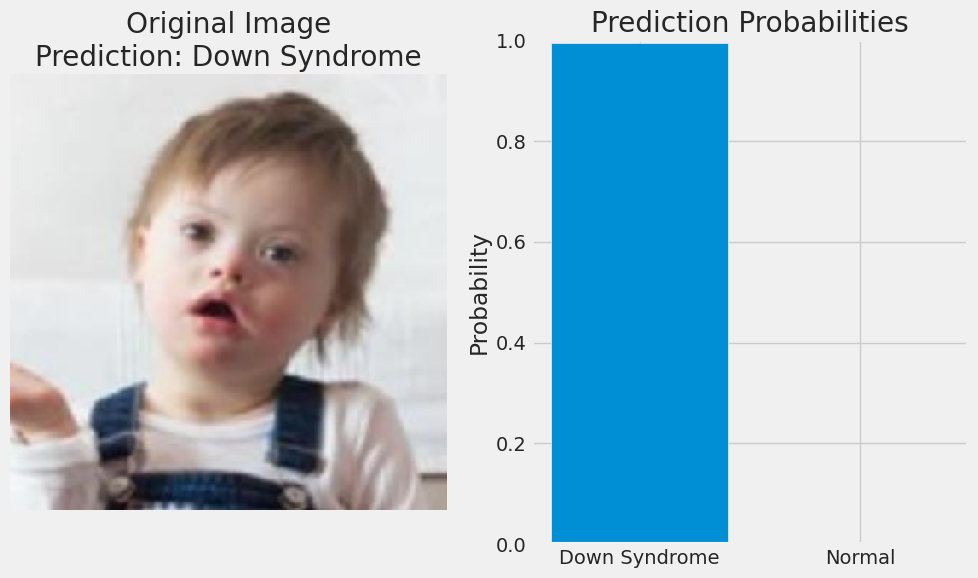

TESTING MULTIPLE IMAGES

--- Image 1: /content/data_split/test/downSyndrome/down_1124.jpg ---
Loading image: /content/data_split/test/downSyndrome/down_1124.jpg
Image shape after preprocessing: (1, 224, 224, 3)
Image pixel value range: 0.0000 to 0.9176

Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Binary classification prediction value: 0.0340

Using threshold: 0.5
Model predicts: Down Syndrome
Confidence: 0.9660


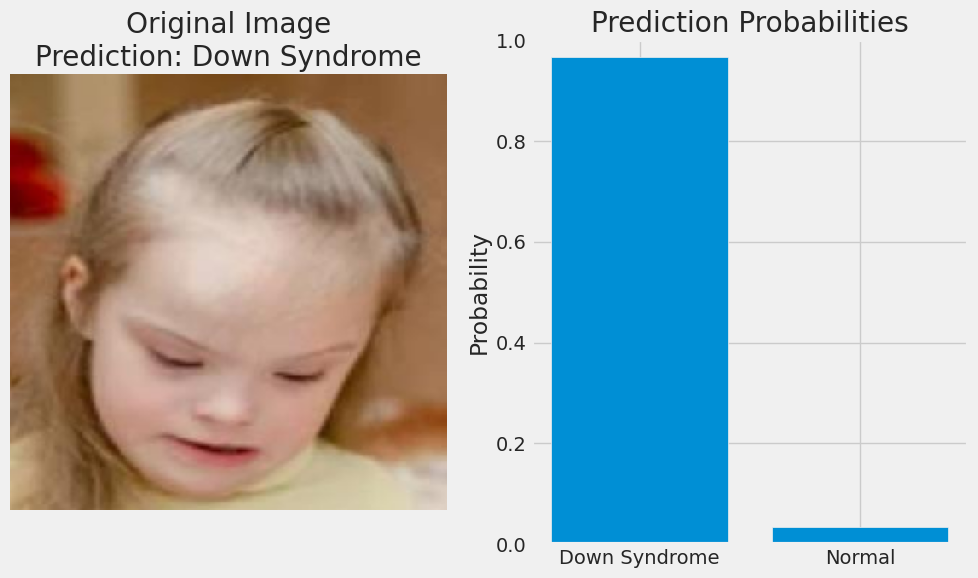

------------------------------

--- Image 2: /content/data_split/test/downSyndrome/down_1218.jpg ---
Loading image: /content/data_split/test/downSyndrome/down_1218.jpg
Image shape after preprocessing: (1, 224, 224, 3)
Image pixel value range: 0.0784 to 0.9529

Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Binary classification prediction value: 0.0034

Using threshold: 0.5
Model predicts: Down Syndrome
Confidence: 0.9966


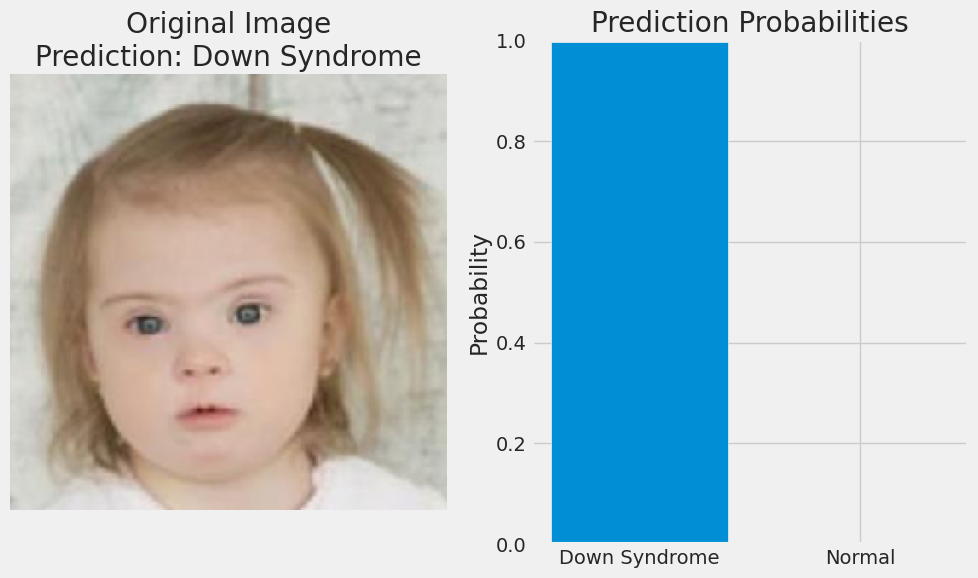

------------------------------

--- Image 3: /content/data_split/test/healty/healty_1186.jpg ---
Loading image: /content/data_split/test/healty/healty_1186.jpg
Image shape after preprocessing: (1, 224, 224, 3)
Image pixel value range: 0.0000 to 1.0000

Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Binary classification prediction value: 0.6179

Using threshold: 0.5
Model predicts: Normal
Confidence: 0.6179


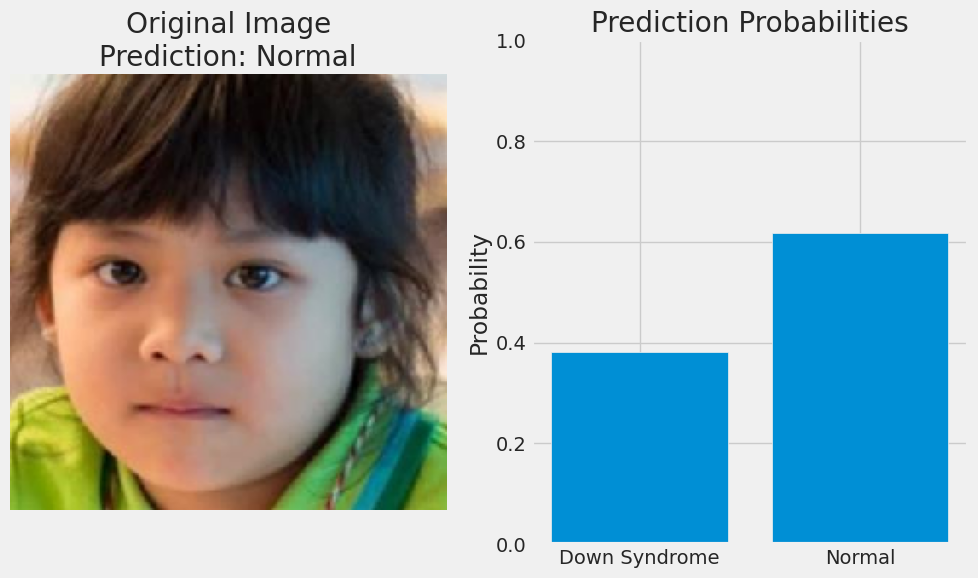

------------------------------

--- Image 4: /content/data_split/test/healty/healty_1200.jpg ---
Loading image: /content/data_split/test/healty/healty_1200.jpg
Image shape after preprocessing: (1, 224, 224, 3)
Image pixel value range: 0.0000 to 1.0000

Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Binary classification prediction value: 0.6299

Using threshold: 0.5
Model predicts: Normal
Confidence: 0.6299


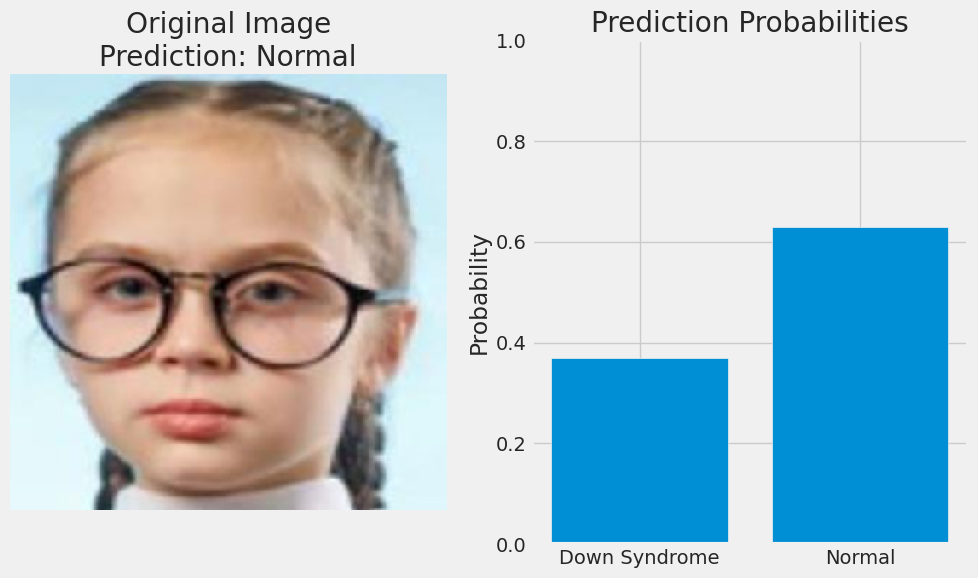

------------------------------

SUMMARY:
Total images tested: 4
Prediction values: [np.float32(0.033981636), np.float32(0.0033741246), np.float32(0.617876), np.float32(0.62987584)]
Min prediction: 0.0034
Max prediction: 0.6299
Mean prediction: 0.3213
Std prediction: 0.3028


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image_debug(img_path, model):
    try:
        # Load and preprocess the image
        print(f"Loading image: {img_path}")
        file = load_img(img_path, target_size=(224, 224))
        img = img_to_array(file)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0

        print(f"Image shape after preprocessing: {img.shape}")
        print(f"Image pixel value range: {img.min():.4f} to {img.max():.4f}")

        # Make prediction
        print("\nMaking prediction...")
        pred = model.predict(img)

        # Extract prediction value
        if len(pred.shape) > 1 and pred.shape[1] > 1:
            # Multi-class output
            pred_value = np.max(pred[0])
            predicted_class = np.argmax(pred[0])
            print(f"Multi-class prediction - Class {predicted_class} with confidence {pred_value:.4f}")
            print("All class probabilities:", pred[0])
        else:
            # Binary classification
            pred_value = pred[0][0] if len(pred.shape) > 1 else pred[0]
            print(f"Binary classification prediction value: {pred_value:.4f}")

        # Interpret prediction (assuming binary classification)
        threshold = 0.5
        print(f"\nUsing threshold: {threshold}")

        if pred_value > threshold:
            print("Model predicts: Normal")
            result = "Normal"
        else:
            print("Model predicts: Down Syndrome")
            result = "Down Syndrome"

        print(f"Confidence: {abs(pred_value - 0.5) + 0.5:.4f}")

        # Display the image
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(file)
        plt.title(f"Original Image\nPrediction: {result}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.bar(['Down Syndrome', 'Normal'],
                [1-pred_value, pred_value] if pred_value <= 1 else [pred_value, 1-pred_value])
        plt.title("Prediction Probabilities")
        plt.ylabel("Probability")
        plt.ylim(0, 1)

        plt.tight_layout()
        plt.show()

        return result, pred_value, pred

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None, None

# Function untuk test multiple images
def test_multiple_images(image_paths, model):
    print("="*50)
    print("TESTING MULTIPLE IMAGES")
    print("="*50)

    predictions = []

    for i, img_path in enumerate(image_paths):
        print(f"\n--- Image {i+1}: {img_path} ---")
        result, pred_value, raw_pred = predict_image_debug(img_path, model)

        if pred_value is not None:
            predictions.append(pred_value)

        print("-" * 30)

    if predictions:
        print(f"\nSUMMARY:")
        print(f"Total images tested: {len(predictions)}")
        print(f"Prediction values: {predictions}")
        print(f"Min prediction: {min(predictions):.4f}")
        print(f"Max prediction: {max(predictions):.4f}")
        print(f"Mean prediction: {np.mean(predictions):.4f}")
        print(f"Std prediction: {np.std(predictions):.4f}")

        # Check if all predictions are similar (indicating potential issue)
        if np.std(predictions) < 0.01:
            print("\n⚠️  WARNING: All predictions are very similar!")
            print("   This might indicate:")
            print("   - Model is not properly trained")
            print("   - Model is overfitting to one class")
            print("   - Preprocessing issue")
            print("   - Model architecture problem")

# Example usage:
if __name__ == "__main__":
    # Test single image
    print("SINGLE IMAGE TEST:")
    result, confidence, raw_pred = predict_image_debug("/content/data_split/test/downSyndrome/down_1044.jpg", model)

    # Test multiple images (ganti dengan path gambar kamu)
    image_list = [
        "/content/data_split/test/downSyndrome/down_1124.jpg",
        "/content/data_split/test/downSyndrome/down_1218.jpg",
        "/content/data_split/test/healty/healty_1186.jpg",
        "/content/data_split/test/healty/healty_1200.jpg"
    ]

    test_multiple_images(image_list, model)